### **PART A**

In [1]:
pip install torch torchvision opencv-python


**Step1:Collect a source video. It may be necessary to divide the video into discrete image frames.**

In [2]:
!mkdir -p video_frames


In [3]:
!ffmpeg -i input_video.mp4 -vf fps=10 video_frames/image%d.png

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [4]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import os

In [5]:
# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 124MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [6]:
def frame_inference(frame, model):
    # Preprocess the frame
    input_tensor = F.to_tensor(frame).unsqueeze(0)

    # Run inference
    with torch.no_grad():
        prediction = model(input_tensor)

    return prediction


In [7]:
def draw_boxes(frame, prediction):
    draw = ImageDraw.Draw(frame)

    for score, box,label in zip(prediction[0]['scores'], prediction[0]['boxes'],prediction[0]['labels']):
        if score > 0.5 and label == 3:
            #print(f"Predicted Label: {label}, Car: {round(score.item(), 3)}")
            box = [round(i, 2) for i in box.tolist()]
            draw.rectangle(box, outline="red", width=2)
            draw.text((box[0], box[1] + 10), f"Car: {round(score.item(), 3)}", fill="red")

    return frame




In [8]:
import os

folder_path = 'video_frames'

# List all files in the folder
files = os.listdir(folder_path)

# Filter files with image extensions (assuming common image extensions like jpg, png, etc.)
image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
total_frames=len(image_files)
# Print the number of images
print(f"Number of images in the folder: {len(image_files)}")

Number of images in the folder: 65


In [9]:
mkdir -p output_frames

In [10]:
for i in range(1,total_frames+1):
  frame = Image.open(f"video_frames/image{i}.png").convert("RGB")
  # Perform inference on the frame
  prediction = frame_inference(frame, model)

  # Drawing bounding boxes on cars
  result_frame = draw_boxes(frame, prediction)

  # Save the output frame
  result_frame.save(f'output_frames/out_frame{i}.jpg')

In [11]:
ls


input_video.mp4  output_frames/  sample_data/  video_frames/


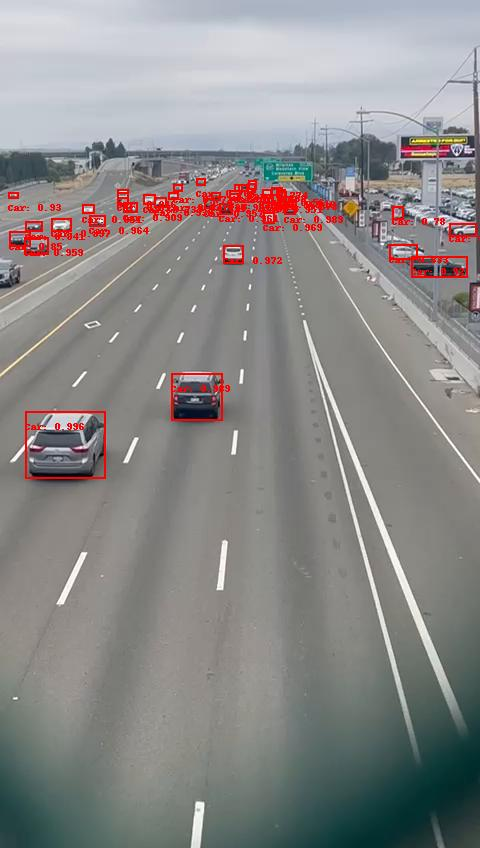

In [16]:
from IPython.display import display, Image
Image(filename='output_frames/out_frame1.jpg', width=400)

In [17]:
!ffmpeg -framerate 20 -i output_frames/out_frame%d.jpg -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p output_video.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

## **PART-B**


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
%cd  /content/drive/MyDrive/My_courses/Yolov8



/content/drive/MyDrive/My_courses/Yolov8


**Download the data from the url link**

In [1]:

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="h1zpNSxTZDpb6PKCkPtS")
project = rf.workspace("yolo-a6y21").project("squid-bat-butterfly")
dataset = project.version(2).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to Squid-Bat-Butterfly-2 in yolov8:: 100%|██████████| 198/198 [00:00<00:00, 4177.09it/s]


**Split and copy data into respective folder**

In [2]:
import os
import shutil
import random

# Set the paths
source_folder_images = '/content/drive/MyDrive/My_courses/Yolov8/Squid-Bat-Butterfly-2/train/images'
source_folder_annotations = '/content/drive/MyDrive/My_courses/Yolov8/Squid-Bat-Butterfly-2/train/labels'
destination_folder_train = '/content/drive/MyDrive/My_courses/Yolov8/data/train'
destination_folder_val = '/content/drive/MyDrive/My_courses/Yolov8/data/val'
destination_folder_test = '/content/drive/MyDrive/My_courses/Yolov8/data/test'

# Set the ratio for splitting the data
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Ensure destination folders exist
os.makedirs(destination_folder_train, exist_ok=True)
os.makedirs(destination_folder_val, exist_ok=True)
os.makedirs(destination_folder_test, exist_ok=True)

# Get a list of all files in the source image folder
all_images = os.listdir(source_folder_images)

# Calculate the number of images for each split
num_train_images = int(len(all_images) * train_ratio)
num_val_images = int(len(all_images) * val_ratio)

# Select random images for training
train_images = random.sample(all_images, num_train_images)
remaining_images = [image for image in all_images if image not in train_images]

# Select random images for validation
val_images = random.sample(remaining_images, num_val_images)

# The remaining images are for testing
test_images = [image for image in remaining_images if image not in val_images]

# Function to copy images and annotations
def copy_files(images, source_folder, destination_folder):
    for i, image in enumerate(images):
        source_image_path = os.path.join(source_folder, image)
        destination_image_path = os.path.join(destination_folder, f"{i+1}.jpg")
        shutil.copyfile(source_image_path, destination_image_path)

        annotation_file = os.path.splitext(image)[0] + ".txt"
        source_annotation_path = os.path.join(source_folder_annotations, annotation_file)
        destination_annotation_path = os.path.join(destination_folder, f"{i+1}.txt")
        shutil.copyfile(source_annotation_path, destination_annotation_path)

# Copy files for training
copy_files(train_images, source_folder_images, destination_folder_train)
print(f"Successfully copied {num_train_images} labeled data pairs to {destination_folder_train} for training.")

# Copy files for validation
copy_files(val_images, source_folder_images, destination_folder_val)
print(f"Successfully copied {num_val_images} labeled data pairs to {destination_folder_val} for validation.")

# Copy files for testing
copy_files(test_images, source_folder_images, destination_folder_test)
print(f"Successfully copied {len(test_images)} labeled data pairs to {destination_folder_test} for testing.")


Successfully copied 57 labeled data pairs to /content/drive/MyDrive/My_courses/Yolov8/data/train for training.
Successfully copied 19 labeled data pairs to /content/drive/MyDrive/My_courses/Yolov8/data/val for validation.
Successfully copied 20 labeled data pairs to /content/drive/MyDrive/My_courses/Yolov8/data/test for testing.


In [3]:
# Pip install method (recommended)

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.7/107.7 GB disk)


In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

**Train**

In [10]:
%cd /content/drive/MyDrive/My_courses/Yolov8

!yolo task=detect mode=train model=yolov8s.pt data= data.yaml epochs=25 imgsz=224 plots=True

/content/drive/MyDrive/My_courses/Yolov8
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=data.yaml, epochs=25, patience=50, batch=16, imgsz=224, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, op

In [11]:
!ls runs/detect/train2/

args.yaml					    R_curve.png       train_batch60.jpg
confusion_matrix.png				    results.csv       train_batch61.jpg
events.out.tfevents.1709160482.a106b7db56c3.5067.0  results.png       train_batch62.jpg
F1_curve.png					    train_batch0.jpg  val_batch0_labels.jpg
P_curve.png					    train_batch1.jpg  val_batch0_pred.jpg
PR_curve.png					    train_batch2.jpg  weights


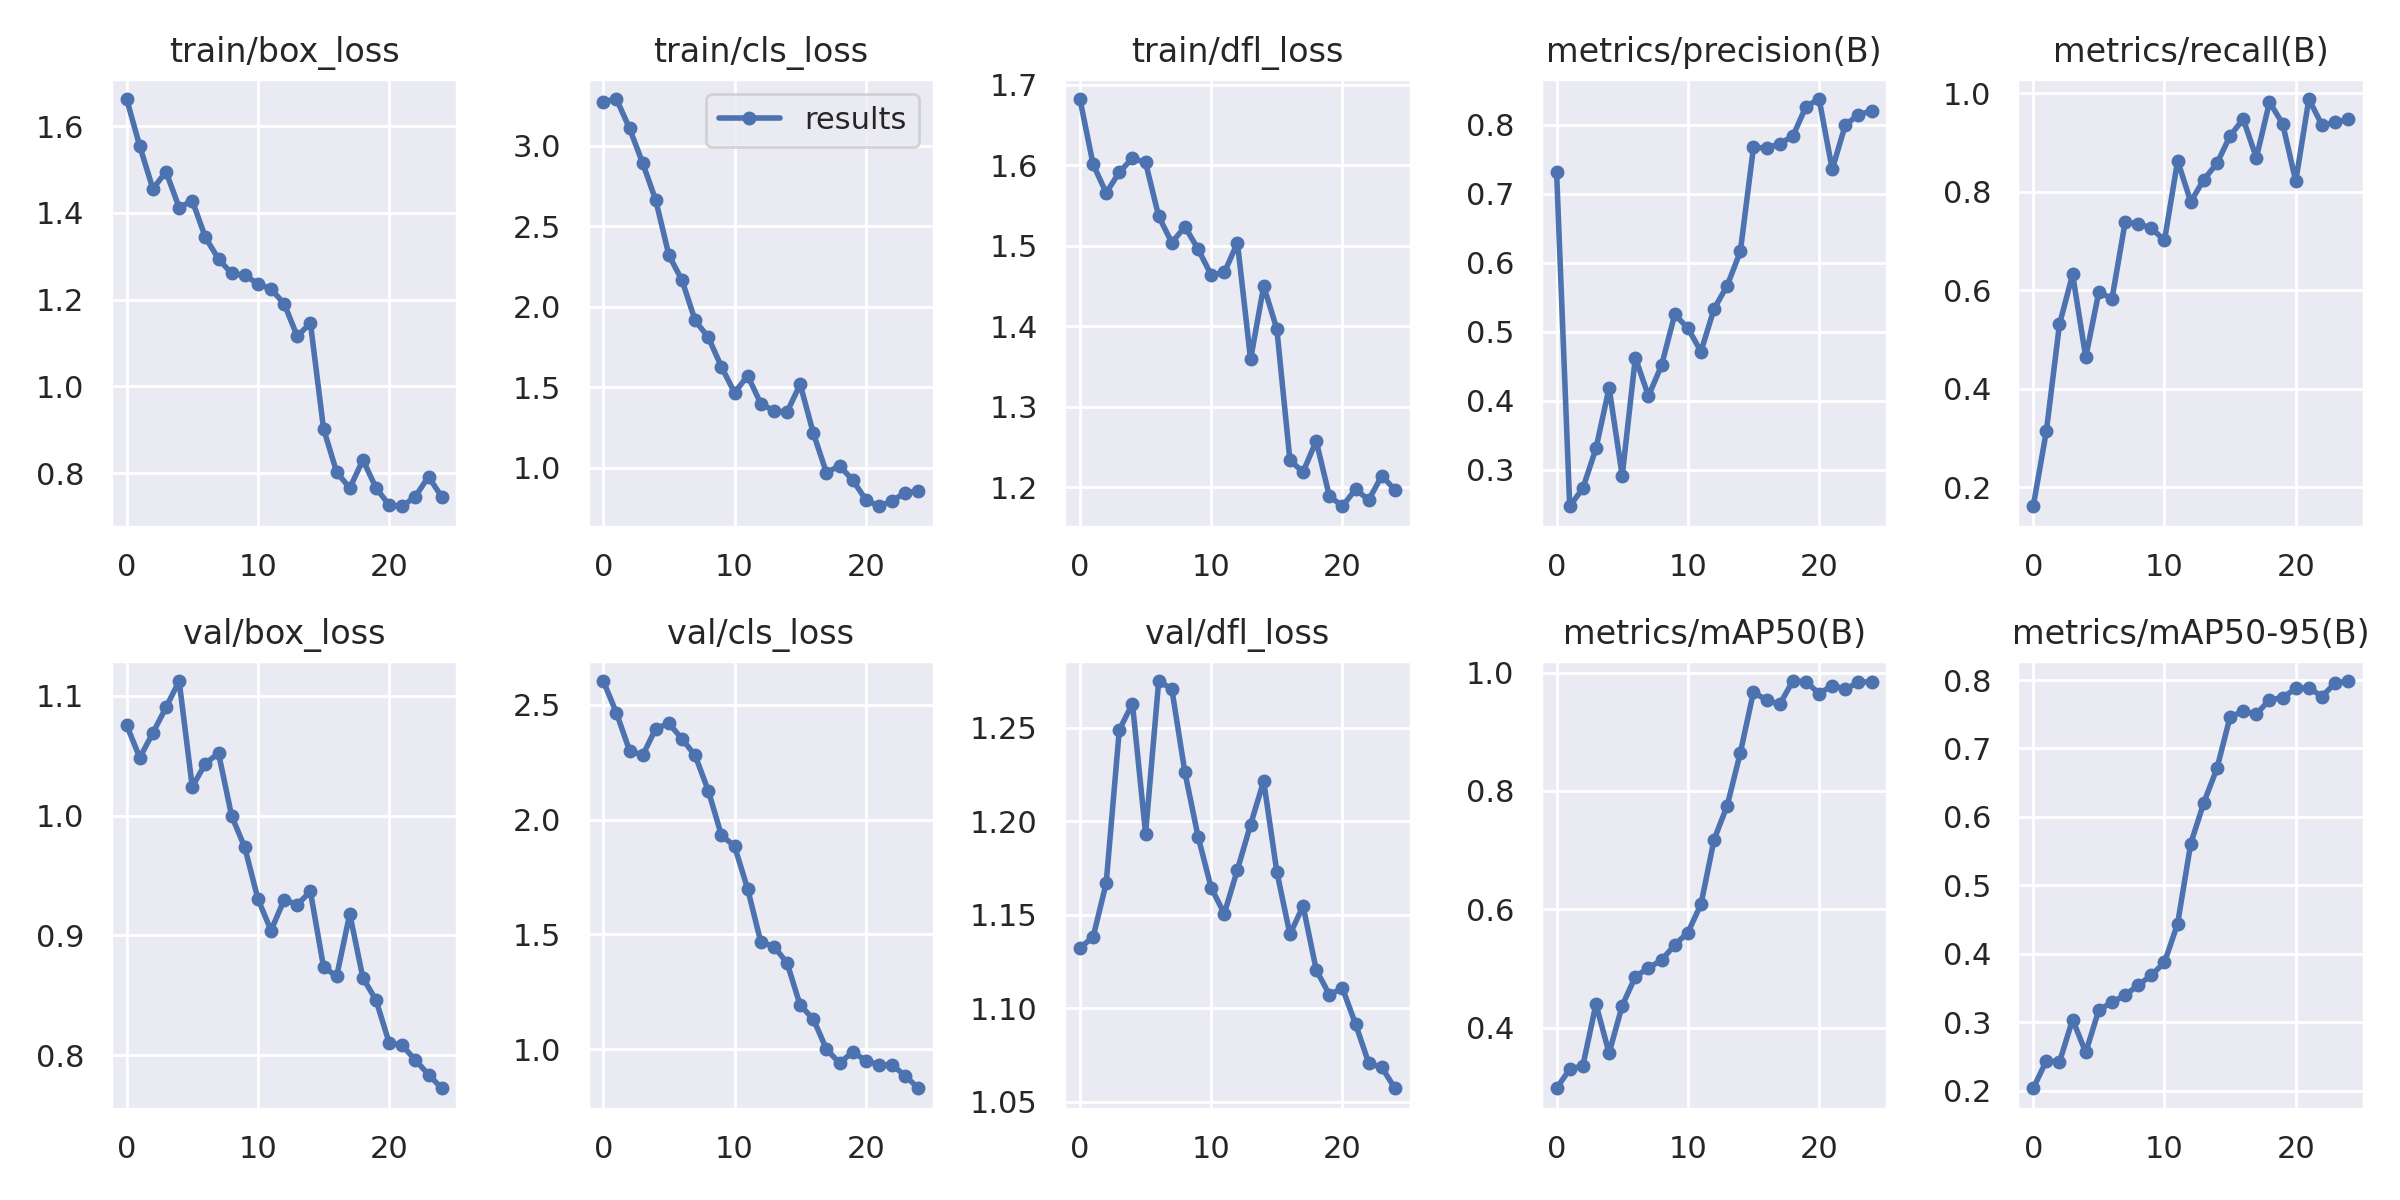

In [12]:
Image(filename='runs/detect/train2/results.png', width=500)

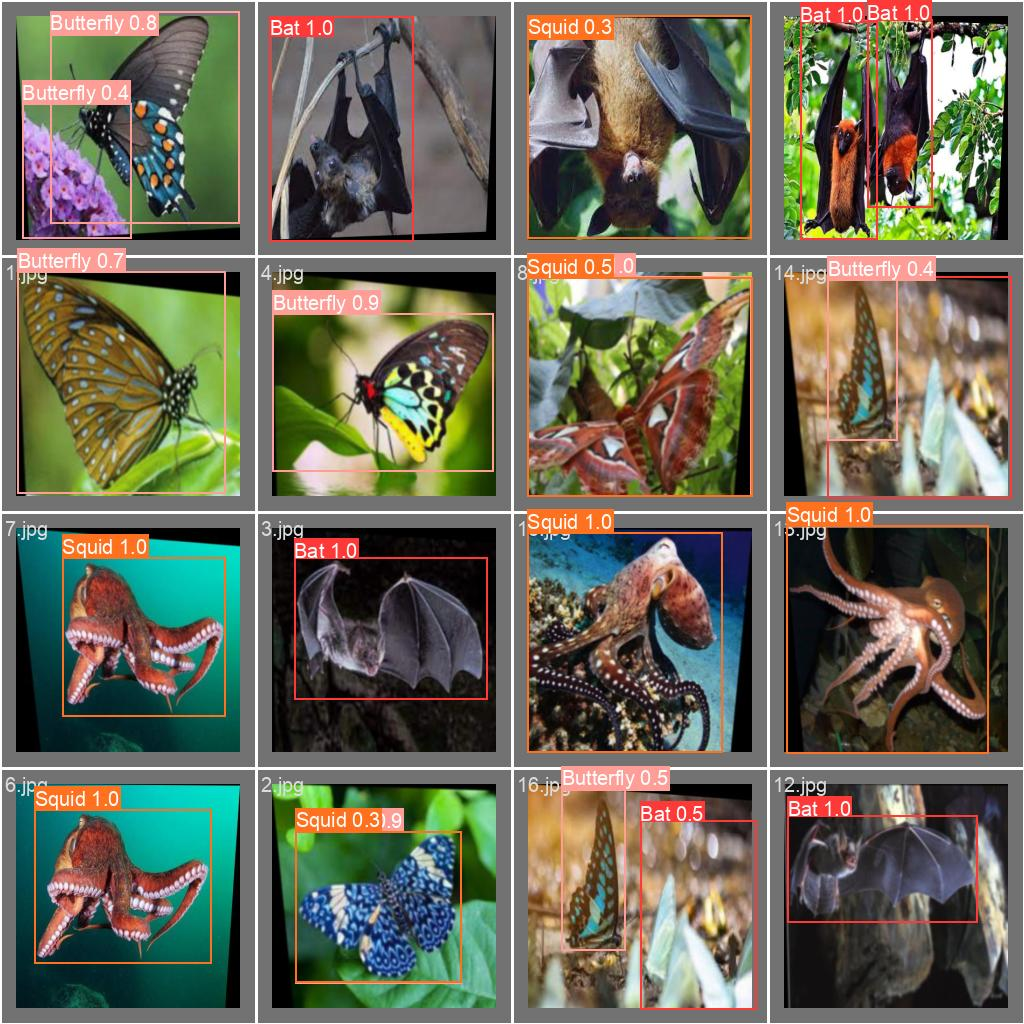

In [13]:
Image(filename='runs/detect/train2/val_batch0_pred.jpg', width=600)

**Validate**


In [14]:
!yolo task=detect mode=val model=runs/detect/train2/weights/best.pt data=data.yaml

2024-02-28 22:57:33.128433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 22:57:33.128518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 22:57:33.130720: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 22:57:35.080845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/drive/MyDrive/My_courses/Yolov8/data/val.cache... 19 images, 0 backgrounds

**Predict**

In [15]:
!yolo task=detect mode=predict model=runs/detect/train2/weights/best.pt conf=0.25 source=data/test

2024-02-28 22:57:51.985342: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 22:57:51.985413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 22:57:51.986915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 22:57:53.283221: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
image 1/20 /content/drive/MyDrive/My_courses/Yolov8/data/test/1.jpg: 224x224 1 Bat, 1 Butterfly, 